#### Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

In [72]:
# For loading packages
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For calculations
import numpy as np

# For data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Model building, tuning and measuring accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# To ignore any warnings
import warnings
warnings.filterwarnings("ignore")

#### Reading The Data

In [73]:
# Reading the train data
train_df = pd.read_csv("train.csv")

# Reading the test data
test_df = pd.read_csv("test.csv")

I'll make a copy of the train and test data incase I need the original datasets.

In [74]:
# Copying the original train and test datasets
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

Let's review the structure of the dataset - what are the features.

In [75]:
# View columns of the train data
train_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

There are 13 independent variables and 1 target variable (Transported) in the training dataset. Let's also review the test dataset.

In [76]:
# View columns of the test data
test_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

We have the same set of features in the test dataset as we do the training dataset, with the only difference being that the training dataset has the the additional target feature 'Transported'.

Below is a description for each variable.

Data Field Descriptions 
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Let's have a look at the data types for each variable of the training dataset.

In [77]:
train_df_1.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We can see that the features take one of three formats in the training dataset:<br>

- **object** (Categorical variables) - The categorical variables in the training dataset are: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP and Name.<br>
- **float64** (Float variables i.e. Numerical variables which have some decimal values involved) - The Numerical variables in our train dataset are: Age, RoomService, FoodCourt, ShoppingMall, Spa and VRDeck.<br>
- **bool** (Boolean variables i.e. a variable that has one of the two possible values e.g. True or False) - The Boolean Variables in our dataset is Transported.<br>

Le's look at the shape of our train and test dataset.

In [78]:
# Print the shape of the training dataset
print("The shape of the training dataset is: ", train_df_1.shape)

# Print the shape of the test dataset
print("The shape of the test dataset is: ", test_df_1.shape)

The shape of the training dataset is:  (8693, 14)
The shape of the test dataset is:  (4277, 13)


We have 8693 rows and 14 columns in the training dataset and 4277 rows and 13 columns in the test dataset. <br>

***Univeraiate Analysis***

Here, we're going to analyse each feature individually, to better understand the distribution of its values.

***Target Variable***

We will first look at the target variable i.e. Transported. Since it is a categorical variable, we'll look at it's percentage distrubition and bar plot.

In [79]:
# Calculating the normalised proportions
train_df_1['Transported'].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

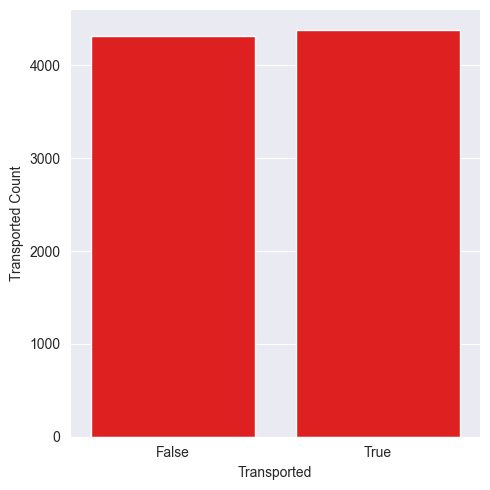

In [80]:
# Visualising the above
ax = sns.catplot(x = "Transported", data = train_df_1, kind = "count", color = "r")
ax.set_axis_labels("Transported", "Transported Count")
plt.show()

Approximately half of all passengers were Transported to another dimension.<br>

Now let's visualise the independent categorical features next.

***Independent Variable (Categorical)***

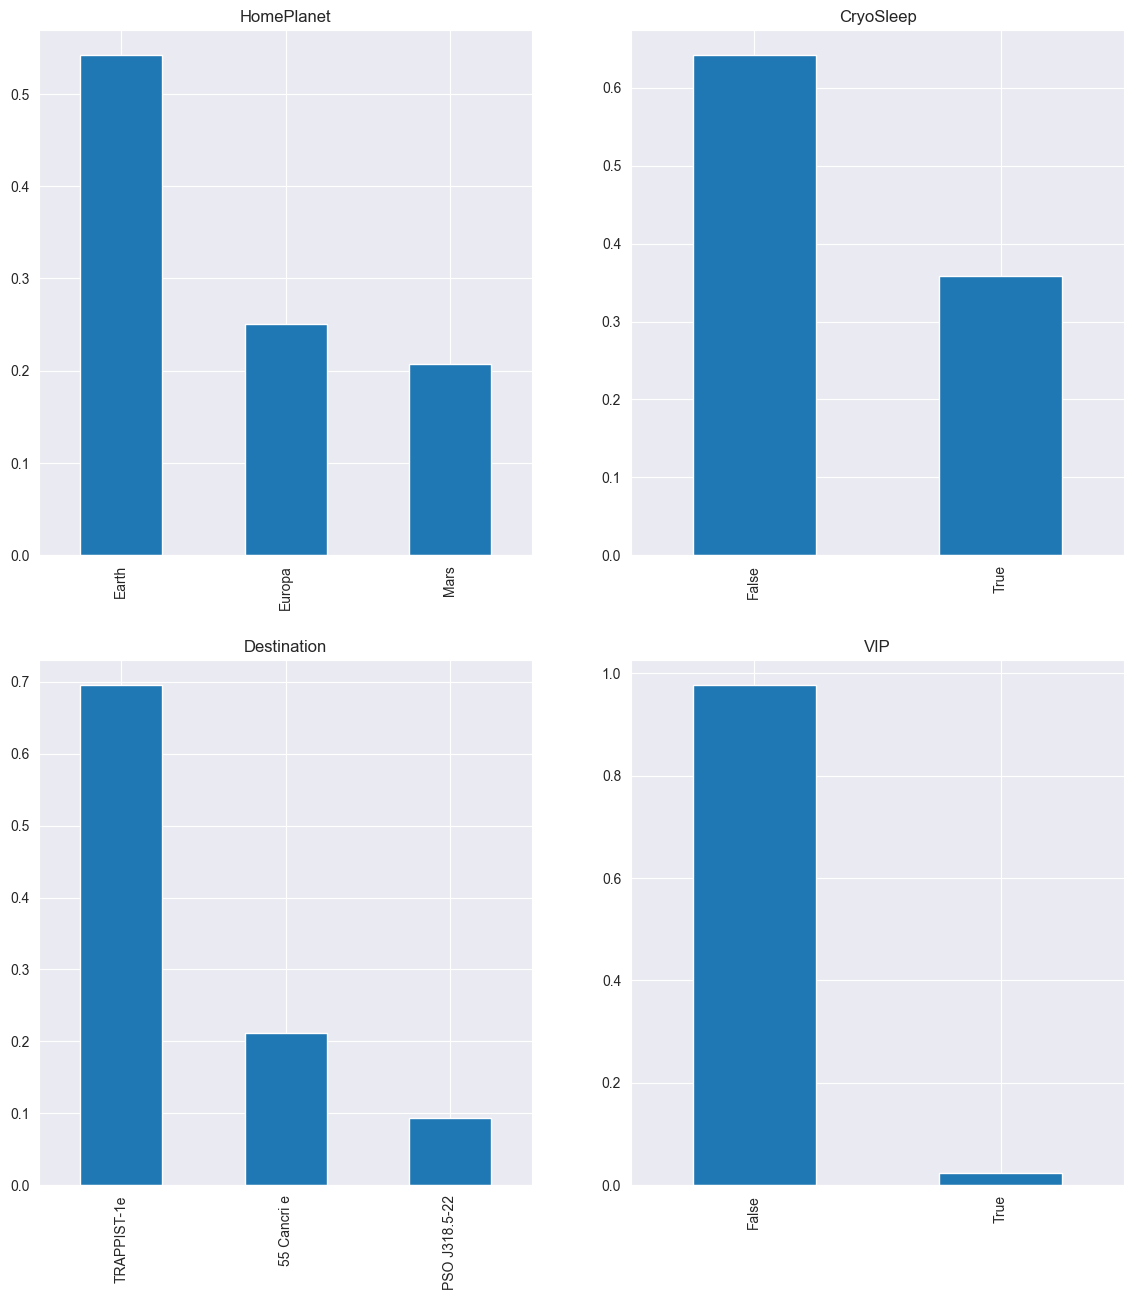

In [81]:
# Visualising independent categorical features
plt.figure(figsize = (14, 15))

plt.subplot(221)
train_df_1['HomePlanet'].value_counts(normalize = True).plot.bar(title = 'HomePlanet')

plt.subplot(222)
train_df_1['CryoSleep'].value_counts(normalize = True).plot.bar(title = 'CryoSleep')

plt.subplot(223)
train_df_1['Destination'].value_counts(normalize = True).plot.bar(title = 'Destination')

plt.subplot(224)
train_df_1['VIP'].value_counts(normalize = True).plot.bar(title = 'VIP')
plt.show()


From the bar plots, we can see the following:
- About 50% of passengers are from Earth
- Approximately 30% of passengers were in CryoSleep
- Almost 70% of passengers were traveling to TRAPPIST-1e
- Less than 1% of passengers paid for the VIP service

Now let's look at the cabin column, which takes the form of deck/num/side. 

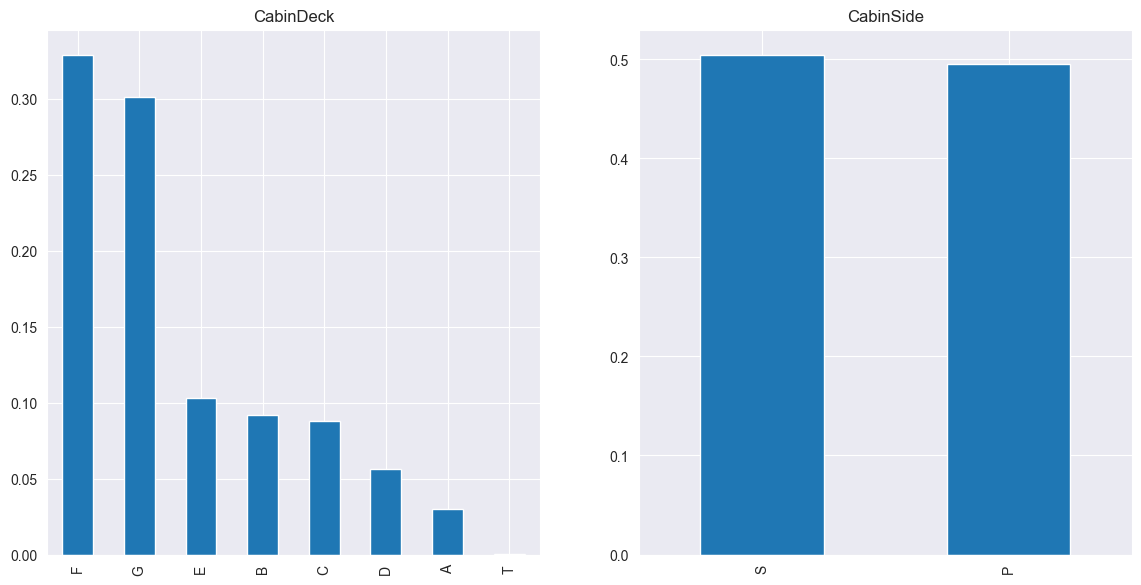

In [82]:
# Extracting the CabinDeck, CabinNo. and CabinSide features from Cabin
train_df_1[["CabinDeck", "CabinNo.", "CabinSide"]] = train_df_1["Cabin"].str.split('/', expand = True)

#Visualize cabin feature
plt.figure(figsize = (14, 15))
plt.subplot(221)
train_df_1['CabinDeck'].value_counts(normalize= True).plot.bar(title = 'CabinDeck')
plt.subplot(222)
train_df_1['CabinSide'].value_counts(normalize= True).plot.bar(title = 'CabinSide')
plt.show()

From the above bar charts, we can see that:
- About 60% of all passengers (in the train set) were on deck F and G
- The passengers in the train set seemed to be almost equally distrubuted amongst the Cabin sides, S and P

That concludes our univariate analysis of the categorical variables. Now let's visualise the numerical variables.



#### Age

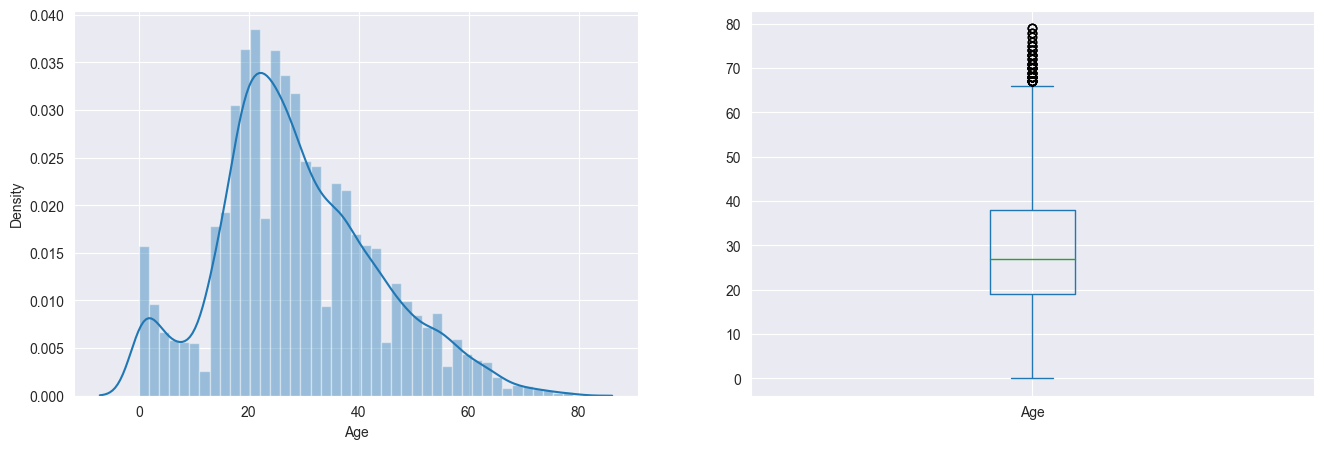

In [83]:
# Visualising the Age variable
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['Age']);
plt.subplot(122)
train_df_1['Age'].plot.box(figsize = (16,5))
plt.show()

The distrubution is that of a gamma distrubution (given the non-negative nature of Age) but it loosely follows a normal distribution (***Need to query this***). It's also worth pointing out there are some outliers, shown by the boxplot.

#### Room Service

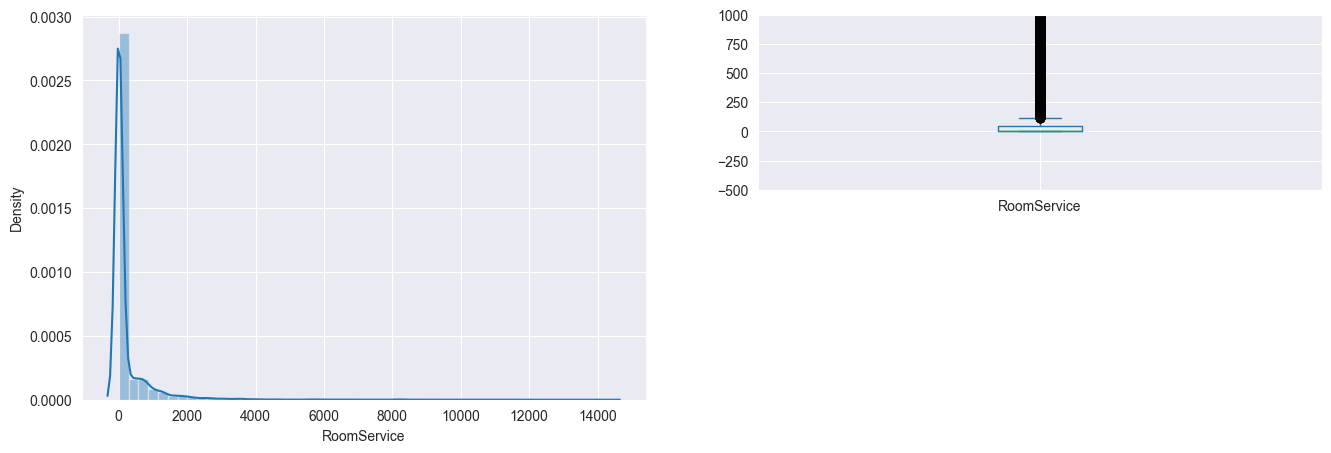

In [84]:
# Visualising the Room Service variable

plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['RoomService'])
plt.subplot(222)
train_df_1['RoomService'].plot.box(figsize = (16,5))
plt.ylim([-500,1000])
plt.show()

As we can see in the distribution, most of the data is towards the left, which means we can't assume it's normally distributed and there are a lot of outliers. We must normalise this data later!

#### Spa

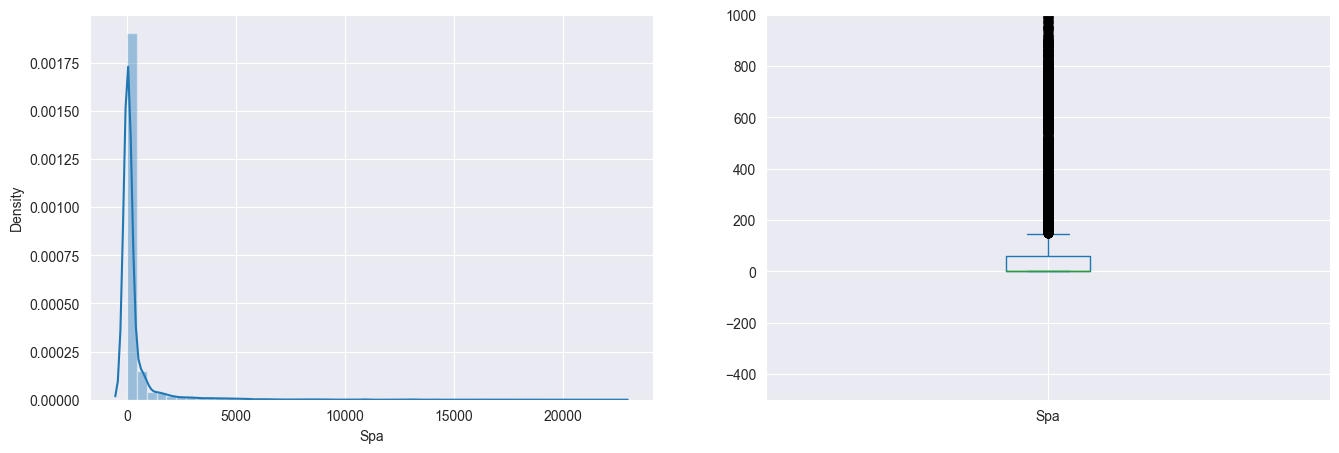

In [85]:
# Visualising the Spa variable
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['Spa'])
plt.subplot(122)
train_df_1['Spa'].plot.box(figsize = (16,5))
plt.ylim([-500, 1000])
plt.show()

The Spa variable has a very similar distribution as that of RoomService. It contains a lot of outliers and is clearly not normally distributed.

Now, RoomService, FoodCourt, ShoppingMall, Spa and VRDeck are the amount the passenger spent on those amenities. It will be interesting to see if FoodCourt, ShoppingMall and VRDeck follow a similar distribution as RoomService and Spa.

#### FoodCourt

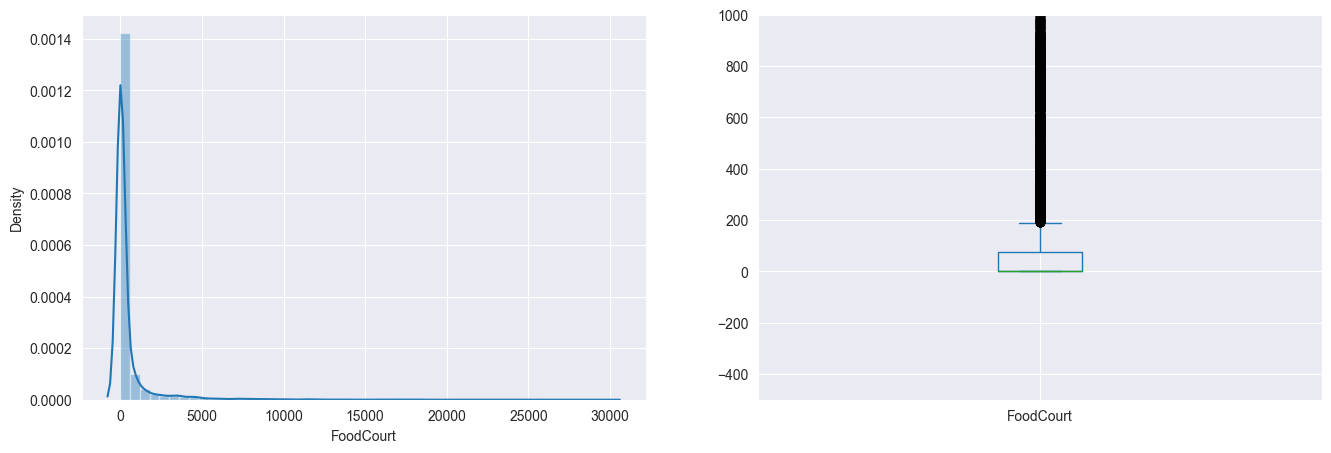

In [86]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['FoodCourt'])
plt.subplot(122)
train_df_1['FoodCourt'].plot.box(figsize = (16, 5))
plt.ylim([-500,1000])
plt.show()

#### ShoppingMall

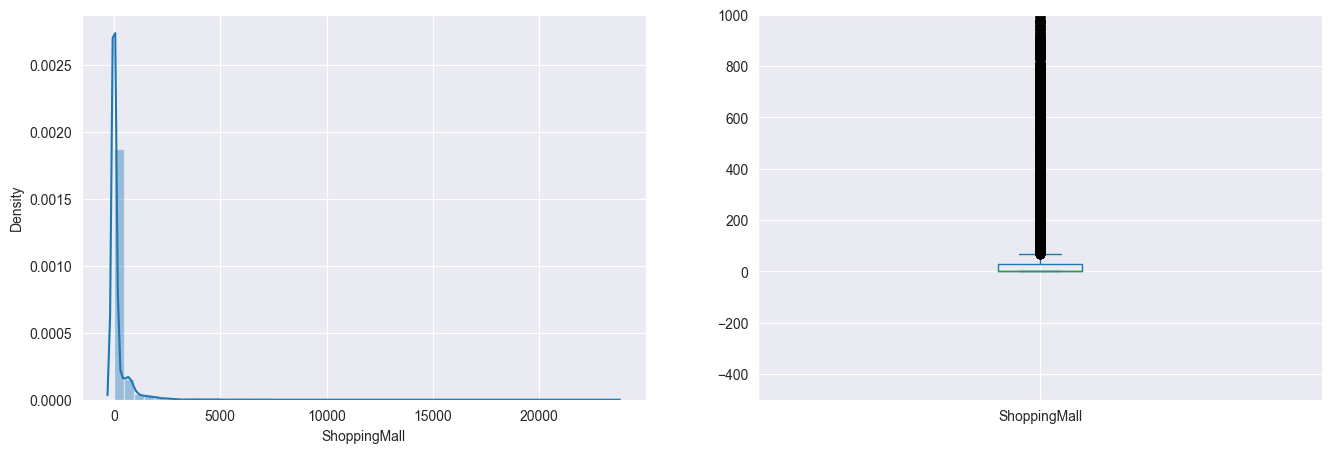

In [87]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['ShoppingMall'])
plt.subplot(122)
train_df_1['ShoppingMall'].plot.box(figsize = (16, 5))
plt.ylim([-500,1000])
plt.show()

#### VRDeck

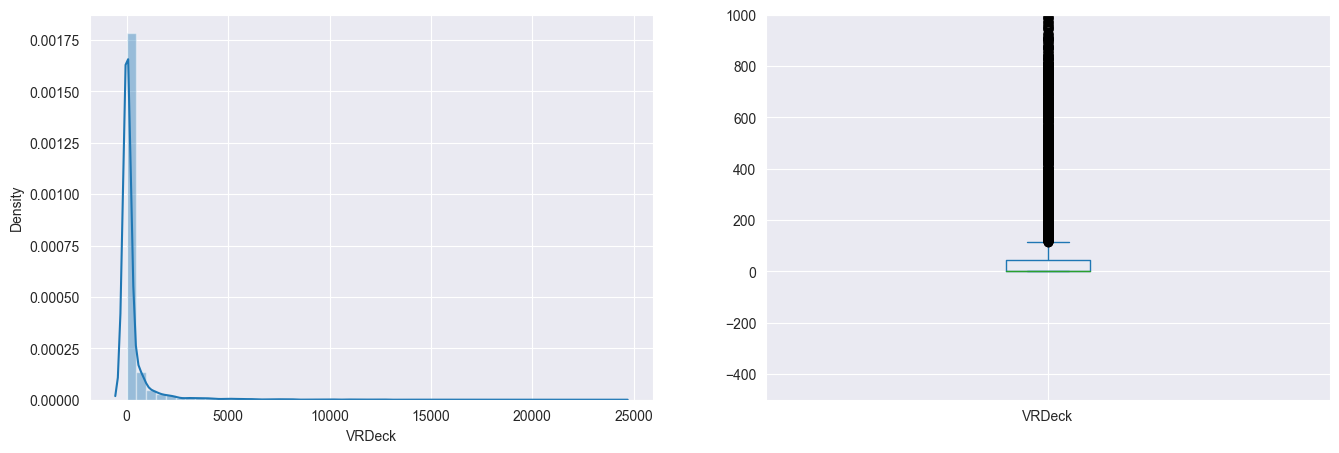

In [88]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['VRDeck'])
plt.subplot(122)
train_df_1['VRDeck'].plot.box(figsize = (16, 5))
plt.ylim([-500,1000])
plt.show()

As we can see from the last few plots, FoodCourt, ShoppingMall and VRDeck have very similar distrubutions to RoomService and Space; skewed towards the left and not normal. They all also have a lot of outliers.

#### Bivariate Analysis

Now that we've completed a univariate analysis of the variables, we will now perform a bivariate analyis, that is to say, the relationship with each of the features with one another, but most importantly, how each of the features relate to the target variable - Transported.

In [89]:
HomePlanet_Transported = train_df_1.groupby('HomePlanet').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
HomePlanet_Transported['TransportedPercentage'] = HomePlanet_Transported['Transported'] / HomePlanet_Transported['PassengerId']


CryoSleep_Transported = train_df_1.groupby('CryoSleep').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
CryoSleep_Transported['TransportedPercentage'] = CryoSleep_Transported['Transported'] / CryoSleep_Transported['PassengerId']

Destination_Transported = train_df_1.groupby('Destination').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
Destination_Transported['TransportedPercentage'] = Destination_Transported['Transported'] / Destination_Transported['PassengerId']

Destination_Transported = train_df_1.groupby('Destination').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
Destination_Transported['TransportedPercentage'] = Destination_Transported['Transported'] / Destination_Transported['PassengerId']

VIP_Transported = train_df_1.groupby('VIP').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
VIP_Transported['TransportedPercentage'] = VIP_Transported['Transported'] / VIP_Transported['PassengerId']
plt.show()

Now let's plot these relations of the categorical variables and the Transported target variable.

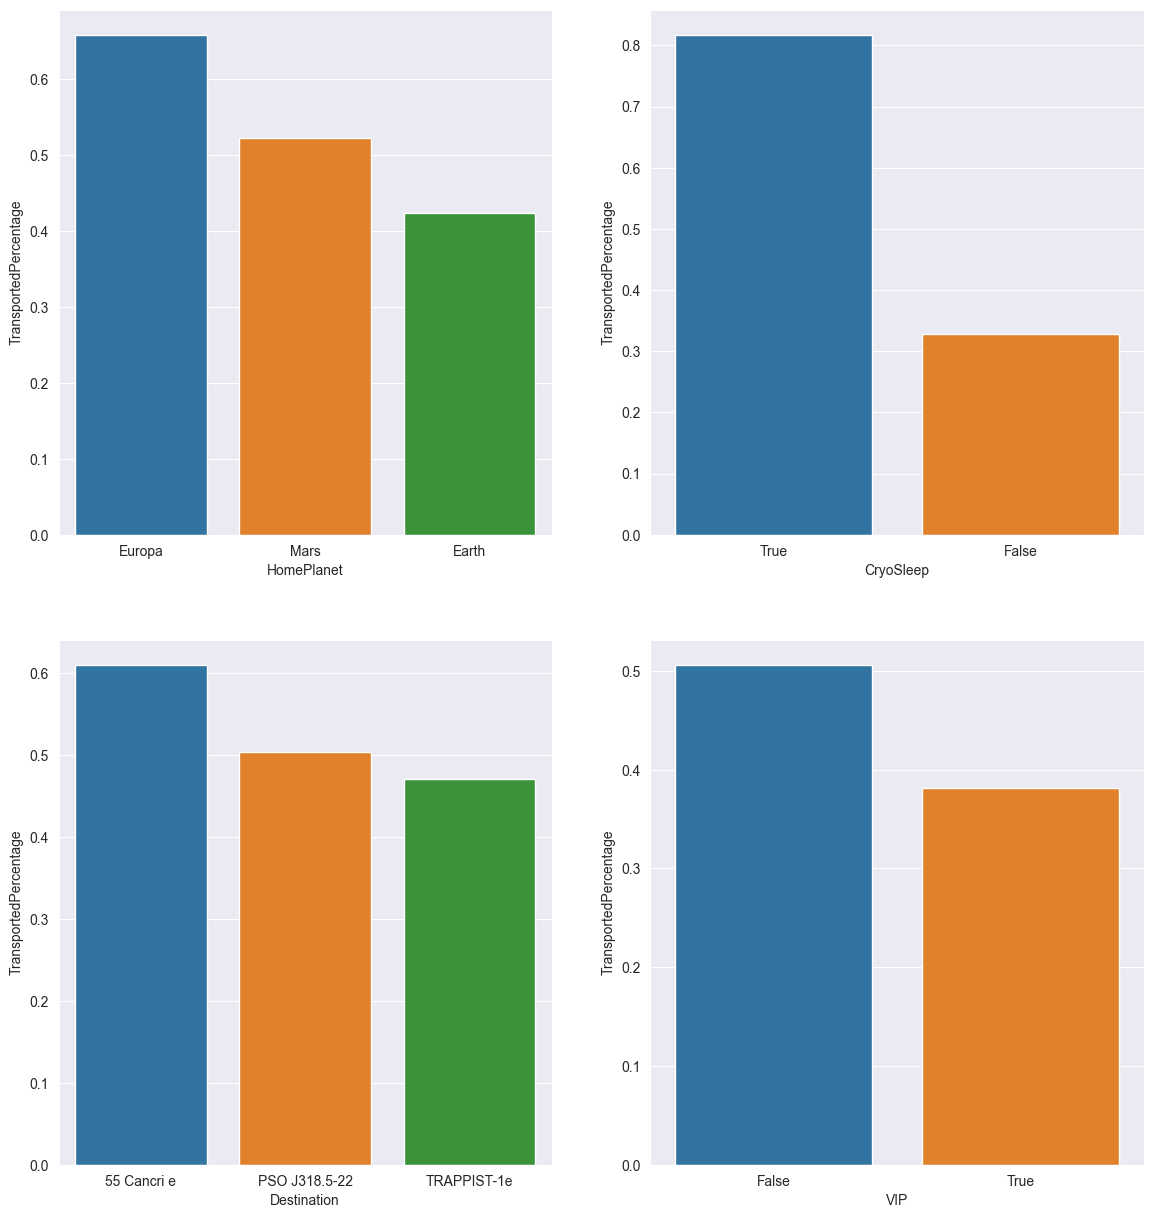

In [90]:

# Visualize categorical features vs target variable
plt.figure(figsize = (14, 15)) 
plt.subplot(221)
sns.barplot(x = "HomePlanet", y = "TransportedPercentage", data = HomePlanet_Transported, order = HomePlanet_Transported.sort_values('TransportedPercentage', ascending = False).HomePlanet)
plt.subplot(222)
sns.barplot(x = "CryoSleep", y = "TransportedPercentage", data = CryoSleep_Transported, order = CryoSleep_Transported.sort_values('TransportedPercentage', ascending = False).CryoSleep)
plt.subplot(223)
sns.barplot(x = "Destination", y = "TransportedPercentage", data = Destination_Transported, order = Destination_Transported.sort_values('TransportedPercentage', ascending = False).Destination)
plt.subplot(224)
sns.barplot(x = "VIP", y = "TransportedPercentage", data = VIP_Transported, order = VIP_Transported.sort_values('TransportedPercentage', ascending = False).VIP)
plt.show()

From the plots we can make the following inferences:
- Approximately 65% of Passengers from Europa were Transported
- About 82% of Passengers in CryoSleep were Transported
- The ratio of Passengers Transported from the Destinations '55 Cancri e', 'PSO J318.5-22' and 'TRAPPIST-1e' is about 12:10:9
- About 38% of Passengers that paid for VIP services were transported

Next we'll perform the same bivariate analysis for CabinDeck and CabinSide columns and how they relate to the target variable, Transported.

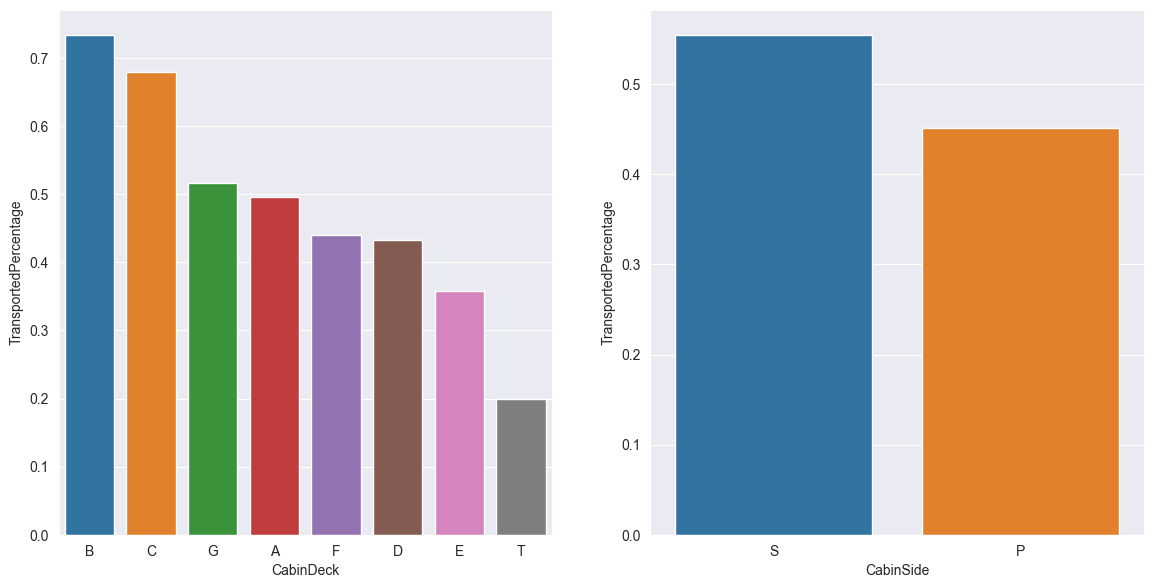

In [91]:
CabinDeck_Transported = train_df_1.groupby('CabinDeck').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()

CabinDeck_Transported['TransportedPercentage'] = CabinDeck_Transported['Transported'] / CabinDeck_Transported['PassengerId']

CabinSide_Transported = train_df_1.groupby('CabinSide').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()

CabinSide_Transported['TransportedPercentage'] = CabinSide_Transported['Transported'] / CabinSide_Transported['PassengerId']

# Visualising the Cabin features against the target feature
plt.figure(figsize = (14,15))
plt.subplot(221)
sns.barplot(x = "CabinDeck", y = "TransportedPercentage", data = CabinDeck_Transported, order = CabinDeck_Transported.sort_values('TransportedPercentage', ascending = False).CabinDeck)
plt.subplot(222)
sns.barplot(x = "CabinSide", y = "TransportedPercentage", data = CabinSide_Transported, order = CabinSide_Transported.sort_values('TransportedPercentage', ascending = False).CabinSide)
plt.show()

- Cabin Deck B and C have the highest percentage of Passengers being Transported
- The proportion of Passengers in the Cabin Side S Transported is greater than those in Cabin Side P

The PassengerId column has instances in the form 'gggg_pp' where gggg represents the group they were travelling with, i.e. family or friends etc. pp represents the number within the group. We want to see if there's any relation between PassengerId and being Transported. In other words, were specific groups or individuals Transported based on who they travelled with?


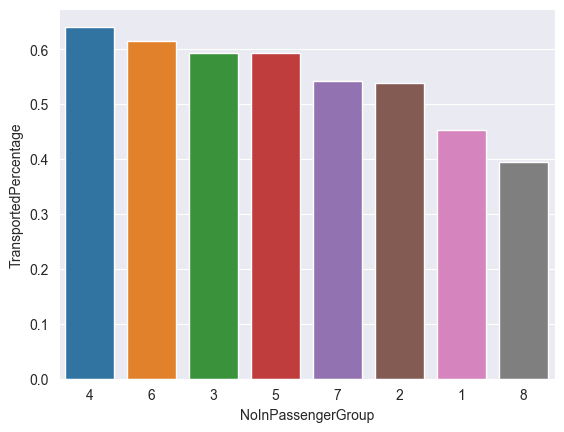

In [92]:

# Extract PassengerGroup column from PassengerId column
train_df_1["PassengerGroup"] = train_df_1["PassengerId"].str.split('_', expand = True)[0]

# Create dataframe -No_People_In_PassengerGroup that contains the PassengerGroup and the no passengers in the group 
No_People_In_PassengerGroup = train_df_1.groupby('PassengerGroup').aggregate({'PassengerId': 'size'}).reset_index()
No_People_In_PassengerGroup = No_People_In_PassengerGroup.rename(columns = {"PassengerId": "NoInPassengerGroup"})

train_df_1 = train_df_1.merge(No_People_In_PassengerGroup[["PassengerGroup", "NoInPassengerGroup"]], how = 'left', on = ['PassengerGroup'])
# create dataframe NoInPassengerGroup_Transported that has No of passengers in a group transported and the percentage of passengers in a group transported
NoInPassengerGroup_Transported = train_df_1.groupby('NoInPassengerGroup').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

NoInPassengerGroup_Transported['TransportedPercentage'] = NoInPassengerGroup_Transported['Transported'] / NoInPassengerGroup_Transported['PassengerId']

# Visualize NoInPassengerGroup vs transported
sns.barplot(x = "NoInPassengerGroup", y = "TransportedPercentage", data = NoInPassengerGroup_Transported, order = NoInPassengerGroup_Transported.sort_values('TransportedPercentage', ascending = False).NoInPassengerGroup)
plt.show()

It's clear to see there is no pattern of how many number of people in a group affects the likelyhood of one being teleported. Let's now look at passengers alone vs not alone, and see if that affects your chances of being teleported.

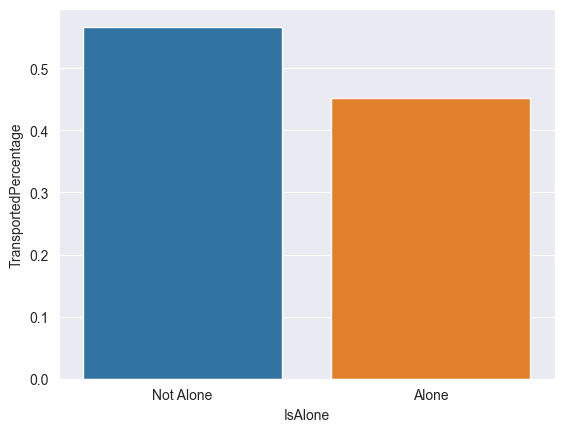

In [93]:

No_People_In_PassengerGroup["IsAlone"] = No_People_In_PassengerGroup["NoInPassengerGroup"].apply(lambda x: "Not Alone" if x > 1 else "Alone")
train_df_1 = train_df_1.merge(No_People_In_PassengerGroup[["PassengerGroup", "IsAlone"]], how = 'left', on = ['PassengerGroup'])

IsAlone_Transported = train_df_1.groupby('IsAlone').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

# create dataframe IsAlone_Transported that contains percentage of passengers transported Alone or Not Alone
IsAlone_Transported['TransportedPercentage'] = IsAlone_Transported['Transported'] / IsAlone_Transported['PassengerId']

# Visualize IsAlone vs transported
sns.barplot(x = "IsAlone", y = "TransportedPercentage", data = IsAlone_Transported, order = IsAlone_Transported.sort_values('TransportedPercentage', ascending = False).IsAlone)
plt.show()

You're about 25% more likely to to be teleported if you are not alone as apposed to being alone.

Now let's look at the family names (surname) and sizes of families to see if there is any correlation between family size and the likelyhood of being teleported.

**Note:** We are going to make the assumption that every person with the same surname is related, which of course may not always be the case. 

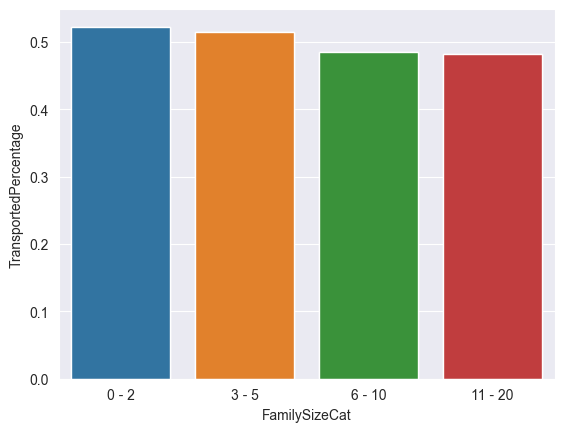

In [104]:
#Obtain the family name from the Name feature
train_df_1["FamilyName"] = train_df_1["Name"].str.split(' ', expand = True)[1]

#Create a new dataframe which has each family name and the number of relatives in that family.
NoRelatives = train_df_1.groupby('FamilyName')['PassengerId'].count().reset_index()
NoRelatives = NoRelatives.rename(columns = {"PassengerId": "NoRelatives"})

train_df_1 = train_df_1.merge(NoRelatives[["FamilyName", "NoRelatives"]], how = 'left')

train_df_1["FamilySizeCat"] = pd.cut(train_df_1.NoRelatives, bins = [0,2,5,10,20], labels = ['0 - 2', '3 - 5', '6 - 10', '11 - 20'])

# create dataframe FamilySizeCat_Transported that has the Family Size Category and the percentage transported
FamilySizeCat_Transported = train_df_1.groupby('FamilySizeCat').aggregate({'Transported': 'sum',
                                                                           'PassengerId': 'size'
                                                                           }).reset_index()

FamilySizeCat_Transported['TransportedPercentage'] = FamilySizeCat_Transported['Transported'] / FamilySizeCat_Transported['PassengerId']

# Visualise FamilySizeCat vs transported
sns.barplot(x = "FamilySizeCat", y = "TransportedPercentage", data = FamilySizeCat_Transported, order = FamilySizeCat_Transported.sort_values('TransportedPercentage', ascending = False).FamilySizeCat)
plt.show()

It's clear that smaller families are slightly more likely to teleported then larger families. Is there any correlation between size of families and how 'rich' they are? and whether or not that affects the likelyhood of being teleported?

Let's add the amount each passenger billed at each of the hospitality services on the spaceship. Plotting against the above (FamilySizeCat)

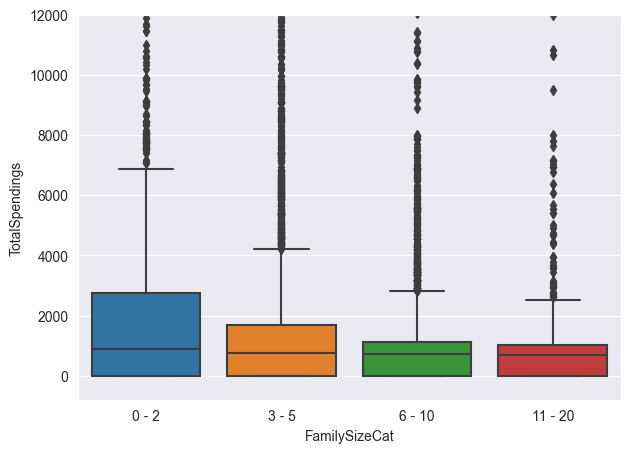

In [108]:
#Create total spending feature
train_df_1["TotalSpendings"] = train_df_1["FoodCourt"] + train_df_1["ShoppingMall"] + train_df_1["RoomService"] + train_df_1["Spa"] + train_df_1["VRDeck"]


 #Plotting FamilySizeCat vs Total Spendings

plt.figure(figsize = (7, 5))
sns.boxplot(data = train_df_1, x = "FamilySizeCat", y = "TotalSpendings")
plt.ylim([-800, 12000])
plt.show()

From the plot above, we can see that smaller families are indeed wealthier and more likely to 

Now let's repeat this exercise of comparing numerical independent variables w.r.t. the target variable, visually.

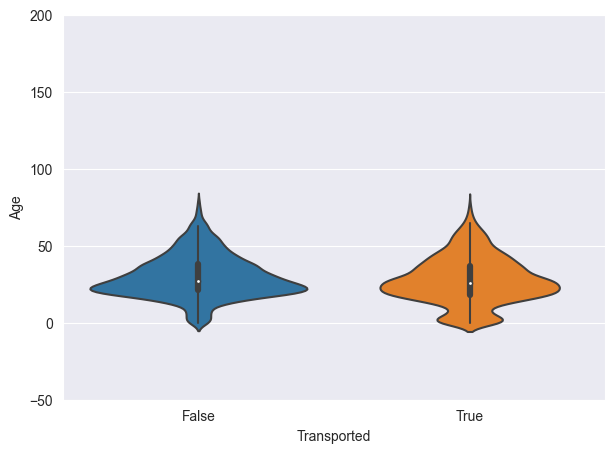

In [114]:
#Transported vs Age
plt.figure(figsize = (7,5))
sns.violinplot(train_df_1["Transported"], train_df_1["Age"])
plt.ylim([-50,200])
plt.show()

There seems to be more very young passengers being teleported then the much older passengers.

We'll create a grouping of ages to verify this.

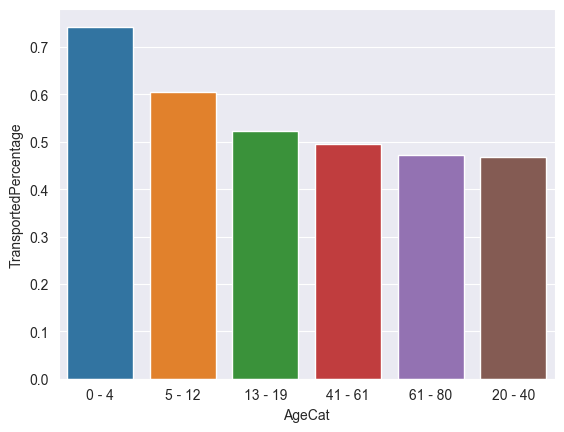

In [128]:

#Getting the Age category from the Age column
train_df_1["AgeCat"] = pd.cut(train_df_1.Age, bins = [0.0, 4.0, 12.0, 19.0, 40.0, 60.0, 80.0], labels = ['0 - 4', '5 - 12', '13 - 19', '20 - 40', '41 - 61', '61 - 80'])

AgeCat_Transported = train_df_1.groupby('AgeCat').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

# create dataframe AgeCat_Transported that has the Age Category and the percentage transported
AgeCat_Transported['TransportedPercentage'] = AgeCat_Transported['Transported'] / AgeCat_Transported['PassengerId']

# Visualize AgeCat vs transported
sns.barplot(x = "AgeCat", y = "TransportedPercentage", data = AgeCat_Transported, order = AgeCat_Transported.sort_values('TransportedPercentage', ascending = False).AgeCat)
plt.show()

From the above, we can make the following inferences:

-About 74% of 0-4 year olds and 60% of 5-12 year olds were teleported. 

Now do the same for the rest of the numerical independent variables.



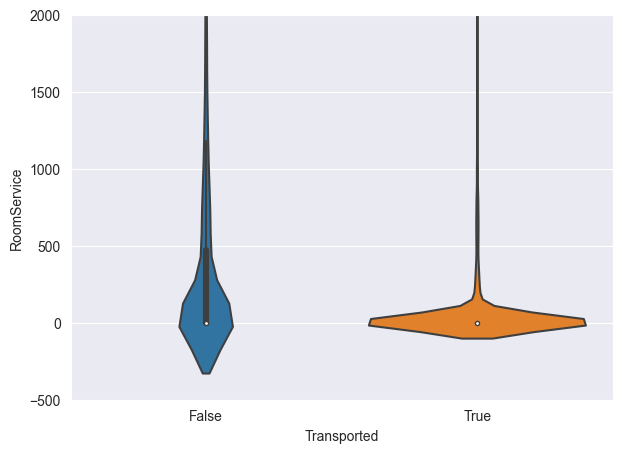

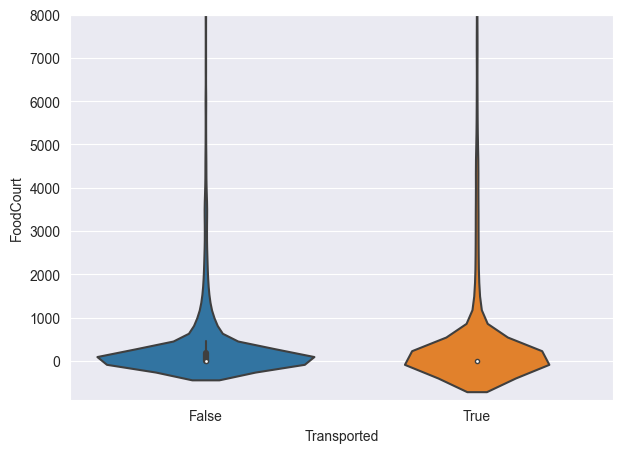

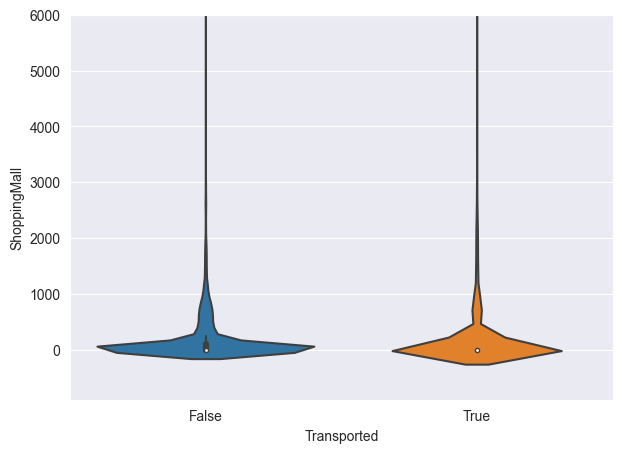

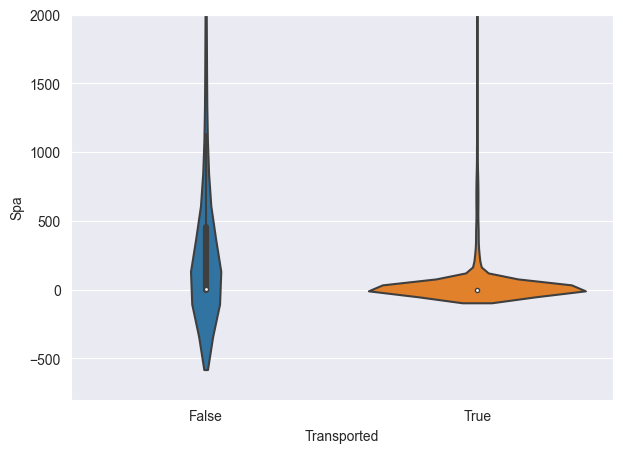

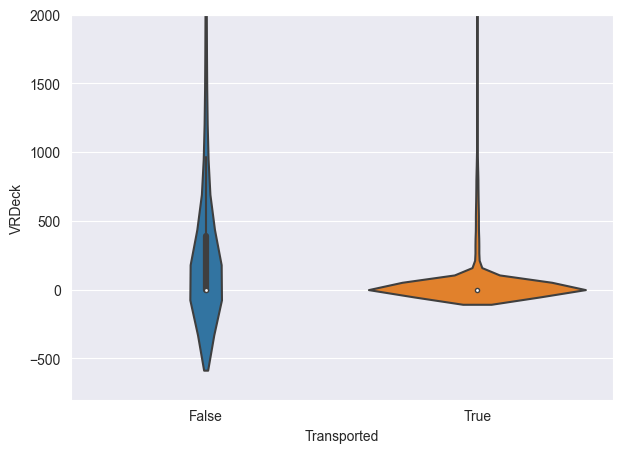

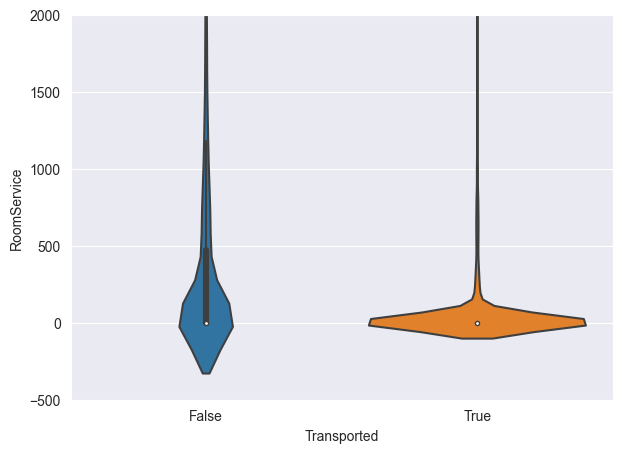

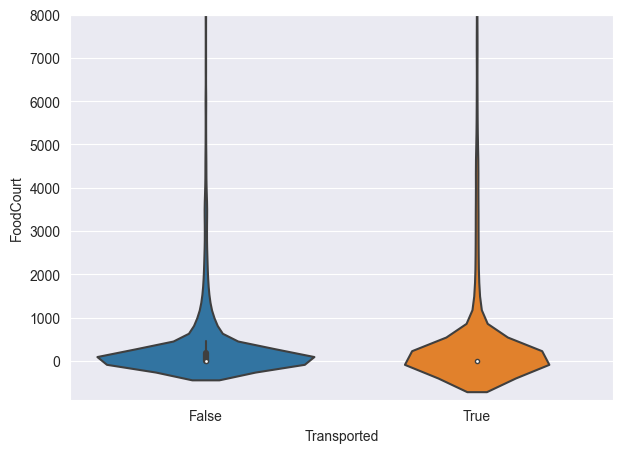

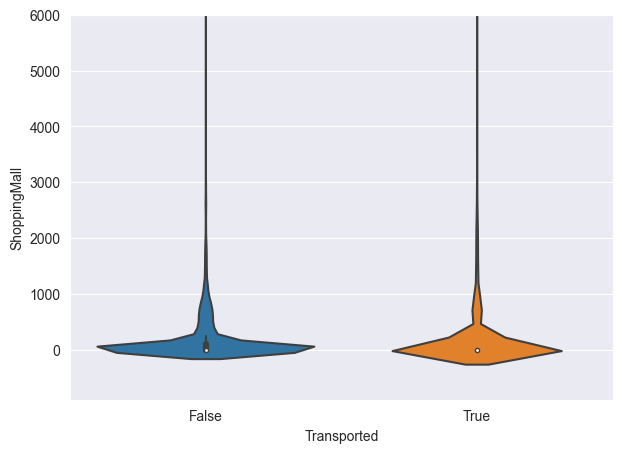

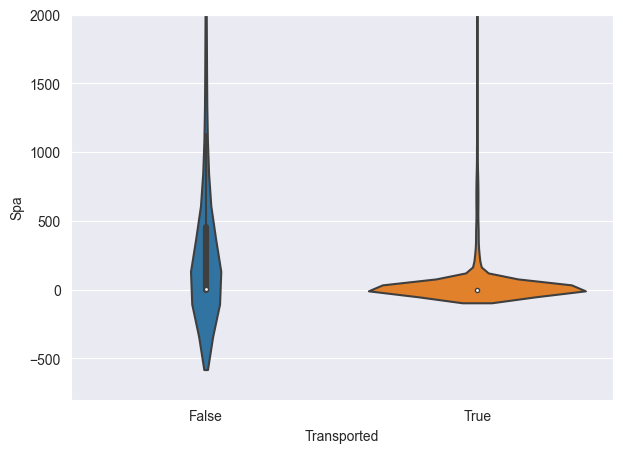

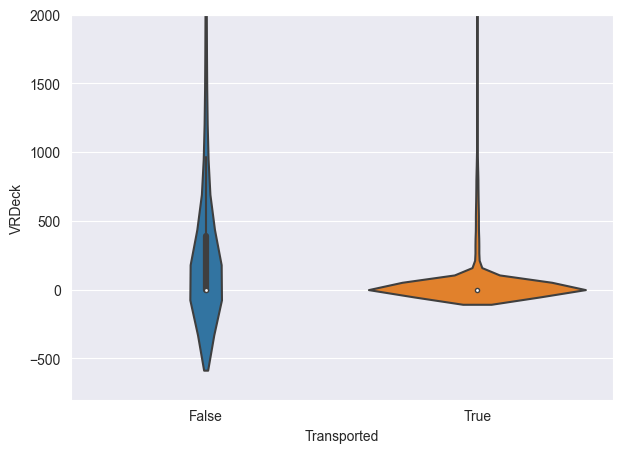

In [130]:
#  RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
plt.figure(figsize = (7, 5)) 
sns.violinplot(train_df_1["Transported"], train_df_1["RoomService"])
plt.ylim([-500, 2000])

plt.figure(figsize = (7, 5))
sns.violinplot(train_df_1["Transported"], train_df_1["FoodCourt"])
plt.ylim([-900, 8000])

plt.figure(figsize = (7, 5))
sns.violinplot(train_df_1["Transported"], train_df_1["ShoppingMall"])
plt.ylim([-900, 6000])

plt.figure(figsize = (7, 5))
sns.violinplot(train_df_1["Transported"], train_df_1["Spa"])
plt.ylim([-800, 2000])

plt.figure(figsize = (7, 5))
sns.violinplot(train_df_1["Transported"], train_df_1["VRDeck"])
plt.ylim([-800, 2000])
plt.show()

The people who were transported had bills centered around 0. 

Now we must check if CryoSleep relates to expenditure.

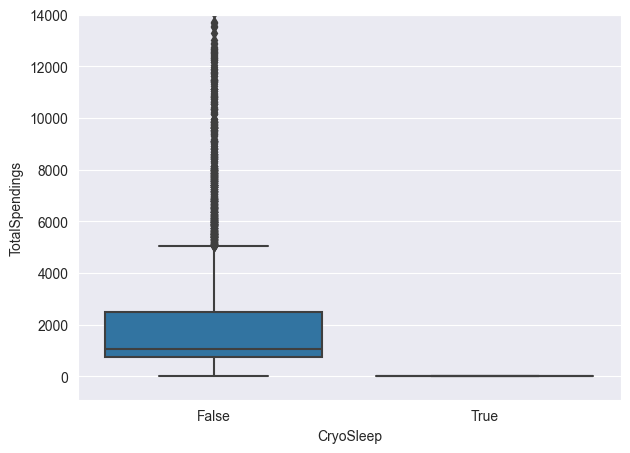

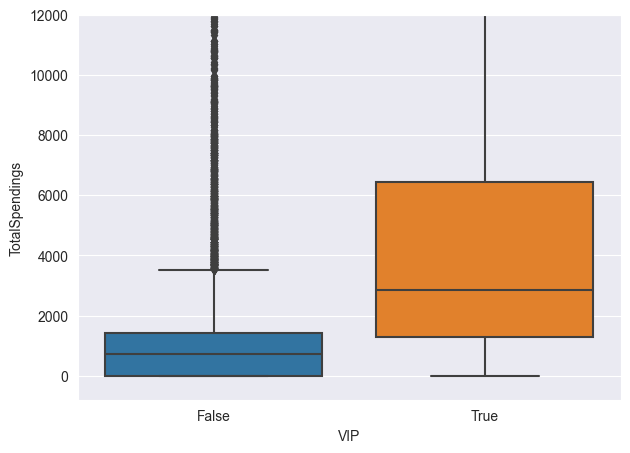

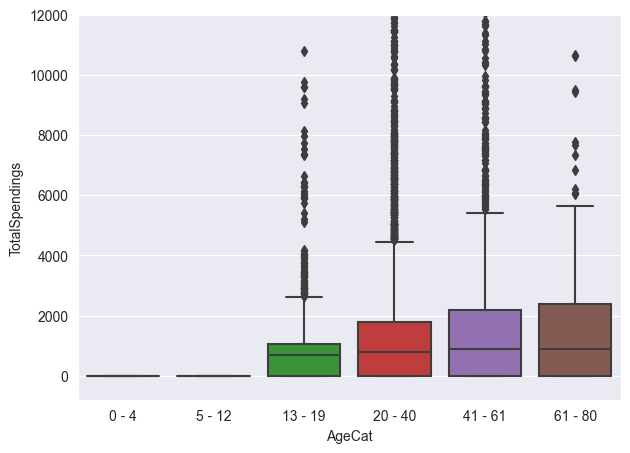

In [134]:
# CryoSleep vs TotalSpendings
plt.figure(figsize = (7, 5))

sns.boxplot(data = train_df_1, x = "CryoSleep", y = "TotalSpendings")
plt.ylim([-900, 14000])

# VIP vs TotalSpendings
plt.figure(figsize = (7, 5))

sns.boxplot(data = train_df_1, x = "VIP", y = "TotalSpendings")
plt.ylim([-800, 12000])

# AgeCat vs TotalSpendings
plt.figure(figsize = (7, 5))
sns.boxplot(data = train_df_1, x = "AgeCat", y = "TotalSpendings")
plt.ylim([-800, 12000])

plt.show()

***Cleaning and Preprocessing***
After our data exploration, let's impute missing values and deal with outliers.

Firstly, let's get rid of any redundant features.

In [140]:
train_df_2 = train_df_1.copy()

# drop features created during EDA
train_df_2 = train_df_2.drop(["PassengerGroup",
                              "CabinDeck",
                              "CabinNo.",
                              "CabinSide",
                              "FamilyName",
                              "NoRelatives",
                              "NoInPassengerGroup",
                              "AgeCat",
                              "FamilySizeCat", 
                              "TotalSpendings",
                              "IsAlone"], axis = 1)

In [141]:
# save target variable in train dataset and save it in target
target = train_df_2["Transported"]

# save test PassengerId in test_id
test_id = test_df_1["PassengerId"]

# drop Transported variable from the train set
train_df_3 = train_df_2.drop(["Transported"], axis = 1)

# Join the train and test set 
data = pd.concat([train_df_3, test_df], axis = 0).reset_index(drop = True)

print(data, data.shape)

      PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0         0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1         0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2         0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3         0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4         0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...           ...        ...       ...       ...            ...   ...    ...   
12965     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
12966     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
12967     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
12968     9273_01     Europa     False   D/297/P            NaN   NaN  False   
12969     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

       RoomService  FoodCourt  Shopping

In [143]:

# view percentage of values missing in each column
round(data.isna().sum() * 100/data.shape[0], 2)

PassengerId     0.00
HomePlanet      2.22
CryoSleep       2.39
Cabin           2.31
Destination     2.11
Age             2.08
VIP             2.28
RoomService     2.03
FoodCourt       2.23
ShoppingMall    2.36
Spa             2.19
VRDeck          2.07
Name            2.27
dtype: float64

In [156]:
#fill in nan values for categorical data

data_temp = data.copy()

#get the columns' names that have categorical data with missing values

list_missing_cat_columns = list((data_temp.select_dtypes(['object', 'category']).isna().sum() > 0).index)

for col in list_missing_cat_columns:
    data_temp[col] = data_temp[col].fillna(data_temp[col].mode()[0])

#fill in nan values for numerical data

list_missing_numerical_columns = list((data_temp.select_dtypes(np.number).isna().sum() > 0).index)

# Filling NaNs based on Age

# Filling NaNs based on Age
def fill_nans_by_age_and_cryosleep(df):
    df["RoomService"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["RoomService"])
    df["FoodCourt"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["FoodCourt"])
    df["ShoppingMall"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["ShoppingMall"])
    df["Spa"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["Spa"])
    df["VRDeck"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["VRDeck"])
    
    return df

data_temp = fill_nans_by_age_and_cryosleep(data_temp)



# Fill numeric columns in train dataset with mean
for col in list_missing_numerical_columns:
    data_temp[col] = data_temp[col].fillna(data_temp[col].mean())
data_temp.isna().sum()


PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

***Dealing with outliers*** 
<br>As we saw in our EDA, some of the features have outliers, let's look at dealing with those.

In [162]:
#Lets clip the outliers at the 99th percentile

def clipping_quantile(dataframe, quantile_value = None, quantile = 0.99):
    DF = dataframe.copy()
    if quantile_value is None:
            quantile_values = DF[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].quantile(quantile)
    for num_column in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
          num_values = DF[num_column].values
          threshold = quantile_values[num_column]
          print(threshold)
          num_values = np.where(num_values > threshold, threshold, num_values)
          DF[num_column] = num_values
    return DF


data_temp = clipping_quantile(data_temp, None, 0.99)

AttributeError: 'NoneType' object has no attribute 'copy'